In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping

# Load Dataset

In [ ]:
#import tensorflow
#tensorflow.keras.backend.set_floatx('float16')

In [3]:
path = '/content/drive/MyDrive/Project/Code/data/archive/original/'
path_all = list(glob.glob(path+'**/*jpg'))
path_Negative = path + 'Negative/*.jpg'
path_Positive = path + 'Positive/*.jpg'

# Visualizing the Dataset

Text(0.5, 1.0, 'Negative and Positive')

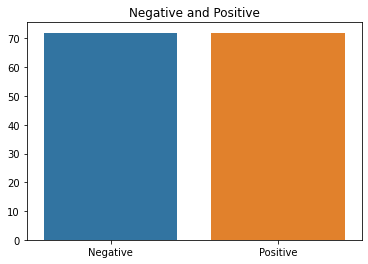

In [4]:
sns.barplot(x=['Negative','Positive'], y=[len(path_Negative), len(path_Positive)])
plt.title('Negative and Positive')

In [5]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label').astype(str)

labels

0        Positive
1        Positive
2        Positive
3        Positive
4        Positive
           ...   
39997    Negative
39998    Negative
39999    Negative
40000    Negative
40001    Negative
Name: Label, Length: 40002, dtype: object

In [6]:


##file_Path = pd.Series(path_all, name='File_Path',dtype=pd.StringDtype())
##labels = pd.Series(labels, name='Label',dtype=pd.StringDtype())

data = pd.concat([file_Path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Label
0,/content/drive/MyDrive/Project/Code/data/archi...,Positive
1,/content/drive/MyDrive/Project/Code/data/archi...,Negative
2,/content/drive/MyDrive/Project/Code/data/archi...,Negative
3,/content/drive/MyDrive/Project/Code/data/archi...,Negative
4,/content/drive/MyDrive/Project/Code/data/archi...,Positive


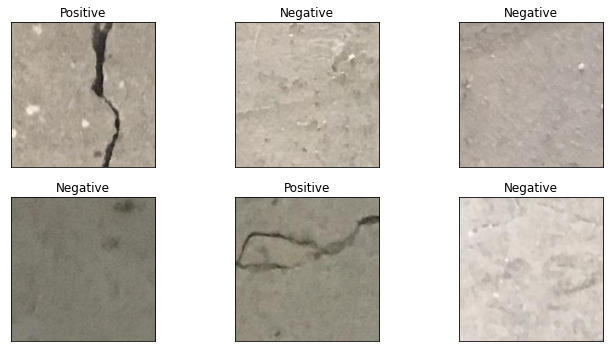

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

# Train & Test Split

In [8]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Functions

In [9]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.2)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=42
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        shuffle=False,
        seed=42
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [10]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input

    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]
    return model, my_callbacks

In [11]:
def plot(history,df_test,test_gen,train_gen, model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(df_test.Label,pred)
    clr = classification_report(df_test.Label, pred, target_names=["NEGATIVE", "POSITIVE"])
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_test.File_Path.iloc[i+1]))
        ax.set_title(f"True: {df_test.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [12]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

# ResNet50 

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
RestNet_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = gen(RestNet_pre,train_df,test_df)

Found 32001 validated image filenames belonging to 2 classes.
Found 32001 validated image filenames belonging to 2 classes.
Found 8001 validated image filenames belonging to 2 classes.


In [14]:
ResNet50_model, callback=func(ResNet50)

94781440/94765736 [==============================] - 1s 0us/step


In [15]:
ResNet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

In [16]:
history = ResNet50_model.fit(
    train_gen_RestNet,
    validation_data=valid_gen_RestNet,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
501/501 [==============================] - 7103s 14s/step - loss: 0.0155 - accuracy: 0.9949 - val_loss: 0.0051 - val_accuracy: 0.9983
Epoch 2/100
501/501 [==============================] - 210s 419ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0017 - val_accuracy: 0.9996
Epoch 3/100
501/501 [==============================] - 210s 419ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0025 - val_accuracy: 0.9990


              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00      3993
    POSITIVE       1.00      1.00      1.00      4008

    accuracy                           1.00      8001
   macro avg       1.00      1.00      1.00      8001
weighted avg       1.00      1.00      1.00      8001



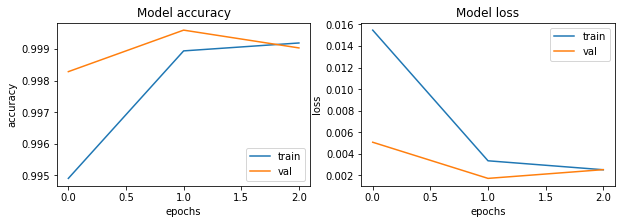

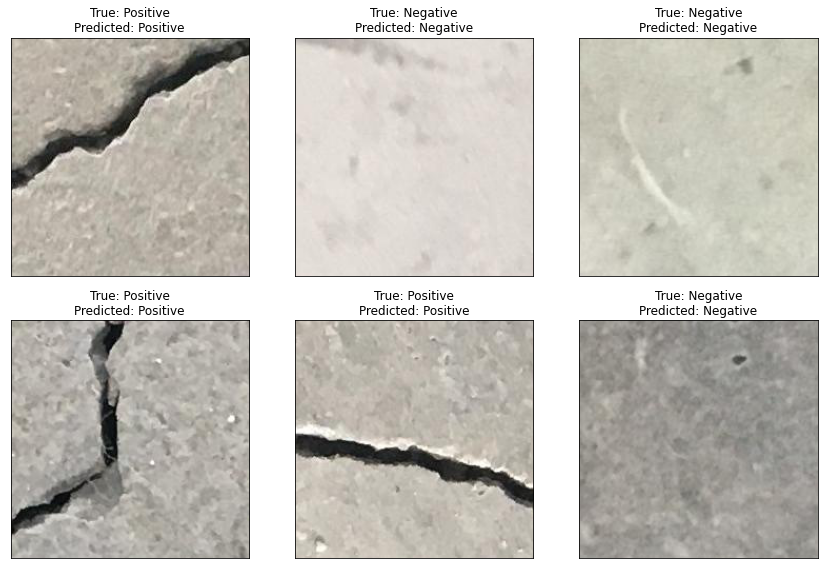

In [17]:
history_ResNet=plot(history,test_df,test_gen_RestNet,train_gen_RestNet,ResNet50_model)

In [18]:
result_ResNet = result_test(test_gen_RestNet,ResNet50_model)

    Test Loss: 0.00966
Test Accuracy: 99.79%


In [19]:
result_ResNet

[0.009660034440457821, 0.9978752732276917]